In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
print(os.listdir("../input"))

['train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv']


In [2]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans

In [3]:
%%time
train = load_df('../input/train_v2.csv')
test = load_df('../input/test_v2.csv')

print('train date:', min(train['date']), 'to', max(train['date']))
print('test date:', min(test['date']), 'to', max(test['date']))

train date: 20160801 to 20180430
test date: 20180501 to 20181015
CPU times: user 13min 44s, sys: 1min 1s, total: 14min 46s
Wall time: 14min 47s


In [4]:
train.shape

(1708337, 30)

In [5]:
test.shape

(401589, 30)

In [6]:
train['totals.transactionRevenue'].describe()

count        18514
unique        7251
top       16990000
freq           308
Name: totals.transactionRevenue, dtype: object

In [7]:
# Thanks and credited to https://www.kaggle.com/gemartin
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 398042601.00 MB
Memory usage after optimization is: 369000872.00 MB
Decreased by 7.3%
Memory usage of dataframe is 93570317.00 MB
Memory usage after optimization is: 86743304.00 MB
Decreased by 7.3%


In [8]:
# only train feature
for c in train.columns.values:
    if c not in test.columns.values: print(c)

In [9]:
train['totals.transactionRevenue'].fillna(0, inplace=True)
train['totals.transactionRevenue'] = np.log1p(train['totals.transactionRevenue'].astype(float))
print(train['totals.transactionRevenue'].describe())

count    1.708337e+06
mean     1.925875e-01
std      1.844057e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.386437e+01
Name: totals.transactionRevenue, dtype: float64


In [10]:
test['totals.transactionRevenue'] = np.nan

# 

In [11]:
all_data = train.append(test, sort=False).reset_index(drop=True)

In [12]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 30 columns):
channelGrouping               object
date                          int32
fullVisitorId                 object
visitId                       int32
visitNumber                   int16
visitStartTime                int32
device.browser                object
device.deviceCategory         object
device.isMobile               float16
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     float64
trafficSource.adContent       object
trafficSource.campaign        object
t

In [13]:
null_cnt = train.isnull().sum().sort_values()
print(null_cnt)

channelGrouping                     0
trafficSource.medium                0
trafficSource.campaign              0
totals.transactionRevenue           0
totals.hits                         0
geoNetwork.subContinent             0
geoNetwork.region                   0
trafficSource.source                0
geoNetwork.metro                    0
geoNetwork.country                  0
geoNetwork.continent                0
geoNetwork.networkDomain            0
device.operatingSystem              0
date                                0
fullVisitorId                       0
visitId                             0
geoNetwork.city                     0
visitNumber                         0
customDimensions                    0
visitStartTime                      0
device.browser                      0
device.deviceCategory               0
device.isMobile                     0
totals.pageviews                  239
totals.newVisits               400907
totals.bounces                 836759
trafficSourc

In [14]:
train.head(50)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0.0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,NaN,(not set),NaN,water bottle,organic,NaN,google,"[{'index': '4', 'value': 'EMEA'}]"
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0.0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]"
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1.0,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,0.0,NaN,(not set),True,NaN,(none),NaN,(direct),"[{'index': '4', 'value': 'North America'}]"
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'EMEA'}]"
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0.0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'Central America'}]"
5,Referral,20171016,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,0.0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,NaN,2,1,2,0.0,NaN,(not set),NaN,NaN,(none),/offer/2145,(direct),"[{'index': '4', 'value': 'North America'}]"
6,Referral,20171016,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,0.0,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,NaN,2,1,2,0.0,NaN,(not set),NaN,NaN,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,"[{'index': '4', 'value': 'EMEA'}]"
7,Organic Search,20171016,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,0.0,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,[]
8,Organic Search,20171016,632878546807742341,1508207516,1,1508207516,Chrome,desktop,0.0,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,NaN,2,1,2,0.0,NaN,(not set),NaN,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'Central America'}]"
9,Organic Search,20171016,1259490915281096752,1508165159,2,1508165159,Safari,mobile,1.0,iOS,not available in demo dataset,Europe,Netherlands,not available in demo dataset,(not set),not available in demo dataset,Western Europe,NaN,2,NaN,2,0.0,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'EMEA'}]"


In [15]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    all_data[col].fillna('unknown', inplace=True)

# fillna numeric feature
all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int)

# fillna boolean feature
all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [16]:
all_data['device.isMobile']=all_data['device.isMobile'].astype(int)

In [17]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
for c in constant_column:
    print(c + ':', train[c].unique())

print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: []


In [18]:
for col in train.columns:
    print(col,train[col].nunique())

channelGrouping 8
date 638
fullVisitorId 1323730
visitId 1665802
visitNumber 457
visitStartTime 1667423
device.browser 129
device.deviceCategory 3
device.isMobile 2
device.operatingSystem 24
geoNetwork.city 956
geoNetwork.continent 6
geoNetwork.country 228
geoNetwork.metro 123
geoNetwork.networkDomain 41982
geoNetwork.region 483
geoNetwork.subContinent 23
totals.bounces 1
totals.hits 297
totals.newVisits 1
totals.pageviews 230
totals.transactionRevenue 7252
trafficSource.adContent 76
trafficSource.campaign 33
trafficSource.isTrueDirect 1
trafficSource.keyword 4546
trafficSource.medium 7
trafficSource.referralPath 3196
trafficSource.source 345
customDimensions 6


In [19]:
train['totals.bounces'].describe()

count     871578
unique         1
top            1
freq      871578
Name: totals.bounces, dtype: object

In [20]:
test['totals.bounces'].describe()

count     182678
unique         1
top            1
freq      182678
Name: totals.bounces, dtype: object

In [21]:
all_data['totals.bounces'].describe()

count    2.109926e+06
mean     4.996649e-01
std      5.000000e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: totals.bounces, dtype: float64

In [22]:
train['totals.pageviews'].fillna(1, inplace=True)
train['totals.newVisits'].fillna(0, inplace=True)
train['totals.bounces'].fillna(0, inplace=True)
train['totals.pageviews'] = train['totals.pageviews'].astype(int)
train['totals.newVisits'] = train['totals.newVisits'].astype(int)
train['totals.bounces'] = train['totals.bounces'].astype(int)

# fillna boolean feature
train['trafficSource.isTrueDirect'].fillna(False, inplace=True)
train['device.isMobile']=train['device.isMobile'].astype(int)

In [23]:
for col in train.columns:
    print(col,train[col].nunique())

channelGrouping 8
date 638
fullVisitorId 1323730
visitId 1665802
visitNumber 457
visitStartTime 1667423
device.browser 129
device.deviceCategory 3
device.isMobile 2
device.operatingSystem 24
geoNetwork.city 956
geoNetwork.continent 6
geoNetwork.country 228
geoNetwork.metro 123
geoNetwork.networkDomain 41982
geoNetwork.region 483
geoNetwork.subContinent 23
totals.bounces 2
totals.hits 297
totals.newVisits 2
totals.pageviews 230
totals.transactionRevenue 7252
trafficSource.adContent 76
trafficSource.campaign 33
trafficSource.isTrueDirect 2
trafficSource.keyword 4546
trafficSource.medium 7
trafficSource.referralPath 3196
trafficSource.source 345
customDimensions 6


In [24]:
# pickup any visitor
all_data[all_data['fullVisitorId'] == '8934116514970143966'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews','totals.transactionRevenue']]

,date,visitId,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
664454,20170829,1504068634,1,25,18,0.000000
422426,20170922,1506112800,3,2,2,0.000000
800474,20170926,1506435456,4,30,23,16.156354
2868,20171016,1508160211,5,2,2,0.000000
1,20171016,1508176307,6,2,2,0.000000
7755,20171130,1512072970,7,3,3,0.000000
1183546,20171217,1513517517,8,18,13,16.587474


In [25]:
train_rev = train[train['totals.transactionRevenue'] > 0].copy()
print(len(train_rev))
train_rev.head()

18514


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
433,Organic Search,20171016,9549826748224805897,1508200705,4,1508200705,Chrome,desktop,0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,0,9,0,9,16.536148,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
550,Referral,20171016,3700714855829972615,1508192636,11,1508192636,Chrome,desktop,0,Windows,Irvine,Americas,United States,Los Angeles CA,(not set),California,Northern America,0,15,0,12,15.894952,NaN,(not set),False,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
555,Organic Search,20171016,1572225825161580042,1508162218,6,1508162218,Safari,mobile,1,iOS,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,purechat.com,California,Northern America,0,15,0,15,17.863811,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
597,Referral,20171016,7187192533100162289,1508189401,17,1508189401,Chrome,desktop,0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,18,0,16,16.718579,NaN,(not set),True,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
619,Referral,20171016,7889233516776348524,1508190484,1,1508190484,Chrome,desktop,0,Macintosh,New York,Americas,United States,New York NY,(not set),New York,Northern America,0,21,1,20,16.325923,NaN,(not set),False,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"


In [26]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.sort_values('Revenue').plot.barh(colormap='jet')

## customDimensions

unique customDimensions count: 6


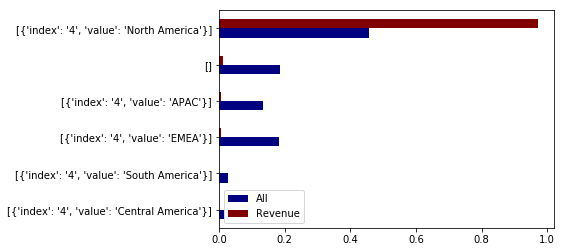

In [27]:
print('unique customDimensions count:', train['customDimensions'].nunique())
plotCategoryRateBar(all_data, train_rev, 'customDimensions')

In [28]:
all_data.head(50)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,unknown,(not set),False,water bottle,organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]"
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,2,0,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]"
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,0,2,1,2,0.0,unknown,(not set),True,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]"
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]"
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]"
5,Referral,20171016,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,0,2,1,2,0.0,unknown,(not set),False,unknown,(none),/offer/2145,(direct),"[{'index': '4', 'value': 'North America'}]"
6,Referral,20171016,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,0,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,"[{'index': '4', 'value': 'EMEA'}]"
7,Organic Search,20171016,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,0,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,[]
8,Organic Search,20171016,632878546807742341,1508207516,1,1508207516,Chrome,desktop,0,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]"
9,Organic Search,20171016,1259490915281096752,1508165159,2,1508165159,Safari,mobile,1,iOS,not available in demo dataset,Europe,Netherlands,not available in demo dataset,(not set),not available in demo dataset,Western Europe,0,2,0,2,0.0,unknown,(not set),True,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]"


## date

In [29]:
format_str = '%Y%m%d'
all_data['date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_year'] = all_data['date'].apply(lambda x:x.year)
all_data['_month'] = all_data['date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['date'].apply(lambda x:x.weekday())

In [30]:
all_data.head(10)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions,_year,_month,_quarterMonth,_day,_weekday
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,unknown,(not set),False,water bottle,organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,2,0,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,0,2,1,2,0.0,unknown,(not set),True,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0
5,Referral,2017-10-16,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,0,2,1,2,0.0,unknown,(not set),False,unknown,(none),/offer/2145,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0
6,Referral,2017-10-16,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,0,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0
7,Organic Search,2017-10-16,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,0,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,[],2017,10,2,16,0
8,Organic Search,2017-10-16,632878546807742341,1508207516,1,1508207516,Chrome,desktop,0,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0
9,Organic Search,2017-10-16,1259490915281096752,1508165159,2,1508165159,Safari,mobile,1,iOS,not available in demo dataset,Europe,Netherlands,not available in demo dataset,(not set),not available in demo dataset,Western Europe,0,2,0,2,0.0,unknown,(not set),True,(

## channelGrouping
* The channel via which the user came to the Store.

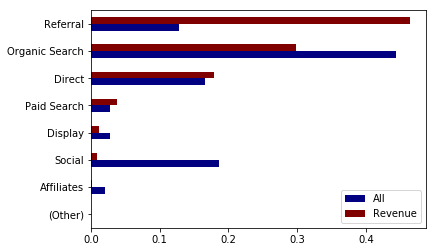

In [31]:
plotCategoryRateBar(all_data, train_rev, 'channelGrouping')

## fullVisitorId
* A unique identifier for each user of the Google Merchandise Store.

## visitId
* An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.   
For a completely unique ID, you should use a combination of fullVisitorId and visitId.

## newVisits


In [32]:
print('train all:', len(train))
print('train unique fullVisitorId:', train['fullVisitorId'].nunique())
print('train unique visitId:', train['visitId'].nunique())
print('-' * 30)
print('test all:', len(test))
print('test unique fullVisitorId:', test['fullVisitorId'].nunique())
print('test unique visitId:', test['visitId'].nunique())

#print('common fullVisitorId:', len(pd.merge(train, test, how='inner', on='fullVisitorId'))) # 183434

train all: 1708337
train unique fullVisitorId: 1323730
train unique visitId: 1665802
------------------------------
test all: 401589
test unique fullVisitorId: 296530
test unique visitId: 393181


In [33]:
print(all_data['visitNumber'].value_counts()[:5])
print('-' * 30)
print(all_data['totals.newVisits'].value_counts())
print('-' * 30)
print(all_data['totals.bounces'].value_counts())

1    1593495
2     235089
3      92462
4      49195
5      30281
Name: visitNumber, dtype: int64
------------------------------
1    1593495
0     516431
Name: totals.newVisits, dtype: int64
------------------------------
0    1055670
1    1054256
Name: totals.bounces, dtype: int64


In [34]:
#maxVisitNumber = max(all_data['visitNumber'])
#fvid = all_data[all_data['visitNumber'] == maxVisitNumber]['fullVisitorId']
#all_data[all_data['fullVisitorId'] == fvid.values[0]].sort_values(by='visitNumber')

## Visit Start Hour

In [35]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

In [36]:
all_data.head(100)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions,_year,_month,_quarterMonth,_day,_weekday,_visitStartHour
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,unknown,(not set),False,water bottle,organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,0
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,2,0,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,17
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,0,2,1,2,0.0,unknown,(not set),True,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,0
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,16
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0,21
5,Referral,2017-10-16,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,0,2,1,2,0.0,unknown,(not set),False,unknown,(none),/offer/2145,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,23
6,Referral,2017-10-16,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,0,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,11
7,Organic Search,2017-10-16,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,0,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,[],2017,10,2,16,0,2
8,Organic Search,2017-10-16,632878546807742341,1508207516,1,1508207516,Chrome,desktop,0,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0,2
9,Organic Search,2017-10-16,1259490915281096752,1508165159,2,1508165159,Safari,mobile,1,iOS,not available in demo dataset,Europe,Netherlands,not available in demo dataset,(not set),not available in demo dataset,Western Euro

## device

unique browser count: 129


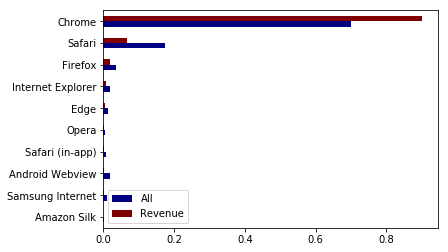

In [37]:
print('unique browser count:', train['device.browser'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.browser', 10)

In [38]:
pd.crosstab(all_data['device.deviceCategory'], all_data['device.isMobile'], margins=False)

all_data['isMobile'] = True
all_data.loc[all_data['device.deviceCategory'] == 'desktop', 'isMobile'] = False

unique operatingSystem count: 24


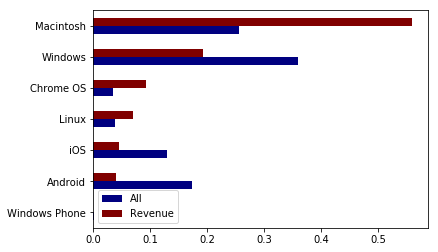

In [39]:
print('unique operatingSystem count:', train['device.operatingSystem'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.operatingSystem', 10)

In [40]:
all_data.head(100)

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions,_year,_month,_quarterMonth,_day,_weekday,_visitStartHour,isMobile
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,0,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,0.0,unknown,(not set),False,water bottle,organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,0,False
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,0,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,0,2,0,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,17,False
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,1,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,0,2,1,2,0.0,unknown,(not set),True,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,0,True
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,0,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,16,False
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,0,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0,21,False
5,Referral,2017-10-16,0166277907528479249,1508196701,1,1508196701,Chrome,desktop,0,Macintosh,San Francisco,Americas,United States,San Francisco-Oakland-San Jose CA,unknown.unknown,California,Northern America,0,2,1,2,0.0,unknown,(not set),False,unknown,(none),/offer/2145,(direct),"[{'index': '4', 'value': 'North America'}]",2017,10,2,16,0,23,False
6,Referral,2017-10-16,8349655975937271469,1508152478,1,1508152478,Chrome,desktop,0,Macintosh,London,Europe,United Kingdom,London,(not set),England,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,unknown,referral,/a/google.com/nest-vision/dropcam-field-tester...,sites.google.com,"[{'index': '4', 'value': 'EMEA'}]",2017,10,2,16,0,11,False
7,Organic Search,2017-10-16,1332629902468998662,1508206208,1,1508206208,Chrome,desktop,0,Windows,not available in demo dataset,Europe,Denmark,not available in demo dataset,fullrate.ninja,not available in demo dataset,Northern Europe,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,[],2017,10,2,16,0,2,False
8,Organic Search,2017-10-16,632878546807742341,1508207516,1,1508207516,Chrome,desktop,0,Macintosh,Mexico City,Americas,Mexico,(not set),uninet-ide.com.mx,Mexico City,Central America,0,2,1,2,0.0,unknown,(not set),False,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'Central America'}]",2017,10,2,16,0,2,False
9,Organic Search,2017-10-16,1259490915281096752,1508165159,2,1508165159,Safari,mobile,1,iOS,not available in demo dataset,Europe,Netherlands,not available in dem

## geoNetwork

unique geoNetwork.city count: 956


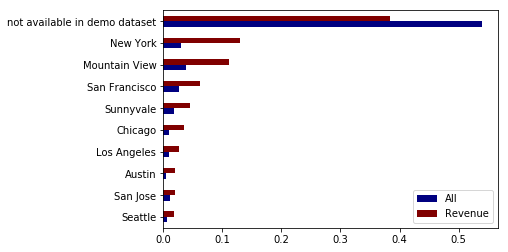

In [41]:
print('unique geoNetwork.city count:', train['geoNetwork.city'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.city', 10)

unique geoNetwork.region count: 483


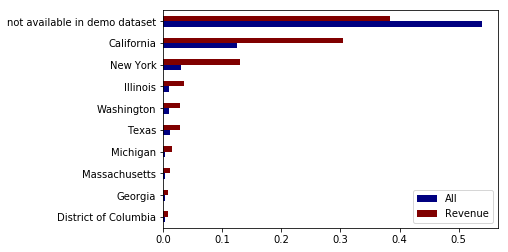

In [42]:
print('unique geoNetwork.region count:', train['geoNetwork.region'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.region', 10)

unique geoNetwork.subContinent count: 23


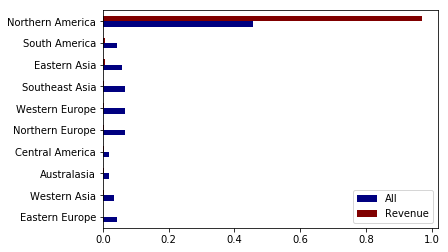

In [43]:
print('unique geoNetwork.subContinent count:', train['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.subContinent', 10)

unique geoNetwork.continent count: 6


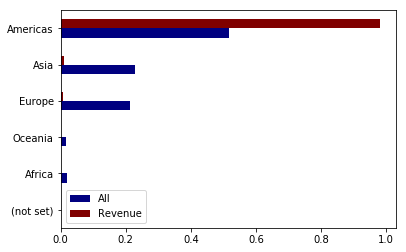

In [44]:
print('unique geoNetwork.continent count:', train['geoNetwork.continent'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.continent')

unique geoNetwork.metro count: 123


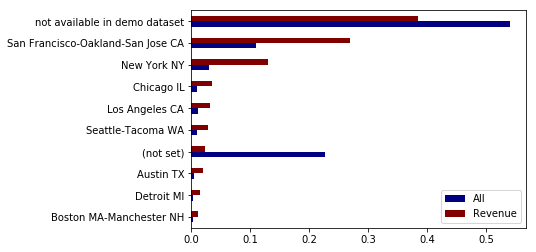

In [45]:
print('unique geoNetwork.metro count:', train['geoNetwork.metro'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.metro', 10)

unique geoNetwork.networkDomain count: 41982


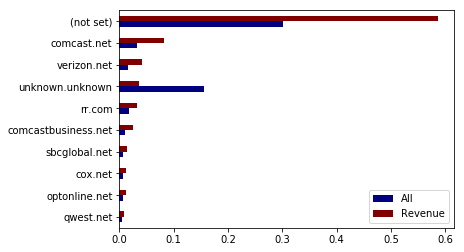

In [46]:
print('unique geoNetwork.networkDomain count:', train['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(all_data, train_rev, 'geoNetwork.networkDomain', 10)

## totals

In [47]:
print(all_data['totals.hits'].value_counts()[:10])

all_data['totals.hits'] = all_data['totals.hits'].astype(int)

1     1045156
2      283836
3      168381
4      102102
5       80768
6       60538
7       49807
8       38821
9       32625
10      26928
Name: totals.hits, dtype: int64


In [48]:
print(all_data['totals.pageviews'].value_counts()[:10])

all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)

1     1060594
2      302017
3      179197
4      110206
5       83130
6       62055
7       49242
8       38807
9       31508
10      25414
Name: totals.pageviews, dtype: int64


In [49]:
#print(all_data['totals.visits'].value_counts())

## trafficSource

In [50]:
print('unique trafficSource.adContent count:', train['trafficSource.adContent'].nunique())

all_data['_adContentGMC'] = (all_data['trafficSource.adContent'] == 'Google Merchandise Collection').astype(np.uint8)

unique trafficSource.adContent count: 76


In [51]:
print('unique trafficSource.campaign count:', train['trafficSource.campaign'].nunique())

all_data['_withCampaign'] = (all_data['trafficSource.campaign'] != '(not set)').astype(np.uint8)

unique trafficSource.campaign count: 33


False    1426999
True      682927
Name: trafficSource.isTrueDirect, dtype: int64


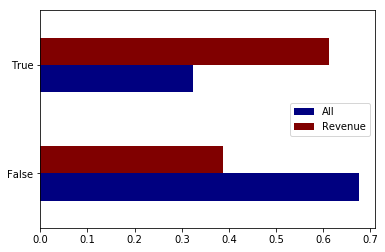

In [52]:
print(all_data['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.isTrueDirect')

unique trafficSource.keyword count: 4546


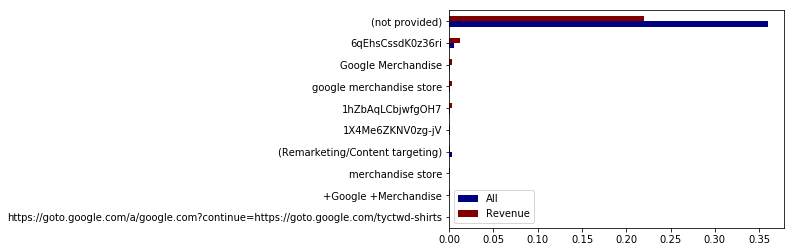

In [53]:
print('unique trafficSource.keyword count:', train['trafficSource.keyword'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.keyword', 10)

unique trafficSource.medium count: 7


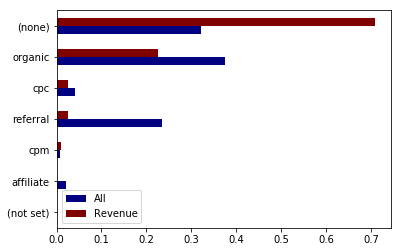

In [54]:
print('unique trafficSource.medium count:', train['trafficSource.medium'].nunique())
plotCategoryRateBar(all_data, train_rev, 'trafficSource.medium')

In [55]:
print('unique trafficSource.referralPath count:', train['trafficSource.referralPath'].nunique())

all_data['_referralRoot'] = (all_data['trafficSource.referralPath'] == '/').astype(np.uint8)

unique trafficSource.referralPath count: 3196


In [56]:
print('unique trafficSource.source count:', train['trafficSource.source'].nunique())

all_data['_sourceGpmall'] = (all_data['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)

unique trafficSource.source count: 345


## Select feature

In [57]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.transactionRevenue    401589
dtype: int64


In [58]:
all_data.drop(['visitId','visitStartTime'],axis=1,inplace=True)

for i, t in all_data.loc[:, all_data.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        all_data[i].fillna('unknown', inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')

# Prediction

In [59]:
train = all_data[all_data['totals.transactionRevenue'].notnull()]
test = all_data[all_data['totals.transactionRevenue'].isnull()].drop(['totals.transactionRevenue'], axis=1)

In [60]:
train=train.drop(['date'],axis=1)
test=test.drop(['date'],axis=1)

In [61]:
train_id = train['fullVisitorId']
test_id = test['fullVisitorId']

Y_train_reg = train.pop('totals.transactionRevenue')
#Y_train_cls = (Y_train_reg.fillna(0) > 0).astype(np.uint8)
X_train = train.drop(['fullVisitorId'], axis=1)
X_test  = test.drop(['fullVisitorId'], axis=1)

print(X_train.shape, X_test.shape,Y_train_reg)

(1708337, 36) (401589, 36)


In [ ]:
del all_data, train, test, train_rev
gc.collect()

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

In [ ]:
!pip install bayesian-optimization

In [77]:
from sklearn.model_selection import StratifiedKFold, GroupKFold,train_test_split
import sklearn.metrics
import lightgbm as lgb

In [99]:
def bayes_parameter_opt_lgb(X_train, Y_train_reg, init_round, opt_round, random_seed, n_estimators, learning_rate):
    # prepare data
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'num_iterations': n_estimators, 'learning_rate':learning_rate, 'early_stopping_round':100, 'objective':'regression',
        'metric':'rmse'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        score=0
        folds = GroupKFold(n_splits=5)
        oof_preds = np.zeros(X_train.shape[0])

        for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train_reg, groups=train_id)):
            trn_x, trn_y = X_train.iloc[trn_], Y_train_reg.iloc[trn_]
            val_x, val_y = X_train.iloc[val_], Y_train_reg.iloc[val_]
    
            reg = lgb.LGBMRegressor(**params)
            reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
            oof_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
            score += sqrt(metrics.mean_squared_error(oof_preds[val_], val_y))/ folds.n_splits
        return -score

    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 45),
                                            'feature_fraction': (0.3, 1),
                                            'bagging_fraction': (0.3, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']


In [84]:
from bayes_opt import BayesianOptimization

In [90]:
import warnings
import time
warnings.filterwarnings("ignore")


In [ ]:
opt_params = bayes_parameter_opt_lgb(X_train, Y_train_reg, init_round=5, opt_round=10, random_seed=6, n_estimators=1000, learning_rate=0.01)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.5368
[1000]	valid_0's rmse: 1.52767
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 1.52766
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.54616
[1000]	valid_0's rmse: 1.53661
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.53659
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.52555
[1000]	valid_0's rmse: 1.51709
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.51709
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.51071
[1000]	valid_0's rmse: 1.50213
Did not meet early stoppin

[500]	valid_0's rmse: 1.51862
[1000]	valid_0's rmse: 1.50654
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.50654
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.52899
[1000]	valid_0's rmse: 1.51603
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.51603
|  7        | -1.523    |  0.5758   |  0.7331   |  4.921    |  0.1816   |  8.793    |  6.255    |  0.09308  |  24.48    |
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.53303
[1000]	valid_0's rmse: 1.52407
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 1.52407
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.54107
[1000]	valid_0's rmse: 1.53134
Did not meet early stopping. Best iteration is:
[998]	valid_0's rmse: 1.53134
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 1.52213
[1000]	valid_0's rmse: 1.5138
Did not

In [ ]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
submission = pd.DataFrame({'fullVisitorId':test_id, 'PredictedLogRevenue':pred})

submission["PredictedLogRevenue"] = np.expm1(submission["PredictedLogRevenue"])
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].apply(lambda x : 0.0 if x < 0 else x)
submission["PredictedLogRevenue"] = submission["PredictedLogRevenue"].fillna(0.0)

submission_sum = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
submission_sum["PredictedLogRevenue"] = np.log1p(submission_sum["PredictedLogRevenue"])
submission_sum.to_csv("submission.csv", index=False)
submission_sum.head(20)

In [ ]:
submission_sum['PredictedLogRevenue'].describe()